In [1]:
import lightning.pytorch as pl
import pytorch_forecasting as pf

print("PyTorch Lightning version:", pl.__version__)
print("PyTorch Forecasting version:", pf.__version__)

PyTorch Lightning version: 2.3.3
PyTorch Forecasting version: 1.0.0


/home/rosh/miniforge3/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import xarray as xr
import ocf_blosc2
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from lightning.pytorch.tuner.tuning import Tuner

In [3]:
forecast_data = pd.read_csv("result_data/tft_data_36_train.csv")
forecast_data = forecast_data.drop(columns=['Unnamed: 0'])

print(forecast_data.shape)
print(forecast_data.columns)

(48348, 27)
Index(['ss_id', 'init_time', 'step', 'pv_datetime', 'pv_hour', 'horizon',
       'generation', 'capacity', 'normalize_generation', 'lat', 'long', 'tilt',
       'orientation', 'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde',
       'sr', 't2m', 'tcc', 'u10', 'u100', 'v10', 'v100'],
      dtype='object')


In [4]:
null_count = forecast_data.isnull().sum()
print(null_count)

ss_id                   0
init_time               0
step                    0
pv_datetime             0
pv_hour                 0
horizon                 0
generation              0
capacity                0
normalize_generation    0
lat                     0
long                    0
tilt                    0
orientation             0
dlwrf                   0
dswrf                   0
duvrs                   0
hcc                     0
lcc                     0
mcc                     0
sde                     0
sr                      0
t2m                     0
tcc                     0
u10                     0
u100                    0
v10                     0
v100                    0
dtype: int64


In [5]:

forecast_data.rename(columns={'pv_hour': 'day_hour'}, inplace=True)

forecast_data['ss_id'] = forecast_data['ss_id'].astype(int)
forecast_data['pv_datetime'] = pd.to_datetime(forecast_data['pv_datetime'])
forecast_data['date'] = forecast_data['pv_datetime'].dt.date
forecast_data['day_of_week'] = forecast_data['pv_datetime'].dt.dayofweek
forecast_data['month'] = forecast_data['pv_datetime'].dt.month

In [6]:
forecast_data.tail(3600)

,ss_id,init_time,step,pv_datetime,day_hour,horizon,generation,capacity,normalize_generation,lat,...,sr,t2m,tcc,u10,u100,v10,v100,date,day_of_week,month
44748,26904,2021-10-24 12:00:00,0 days 00:00:00,2021-10-24 14:00:00,14.0,1.0,154.1736,2.50,61.669440,53.45,...,0.0,283.83765,0.995148,-0.837369,-0.546507,6.326779,10.521592,2021-10-24,6,10
44749,26904,2021-10-24 12:00:00,0 days 01:00:00,2021-10-24 15:00:00,15.0,2.0,167.2272,2.50,66.890881,53.45,...,109312.0,284.89722,0.545685,-1.408195,-1.666104,5.795358,9.145356,2021-10-24,6,10
44750,26904,2021-10-24 12:00:00,0 days 02:00:00,2021-10-24 16:00:00,16.0,3.0,141.4416,2.50,56.576642,53.45,...,1534464.0,285.46630,0.996216,0.945641,1.510382,7.773956,11.154594,2021-10-24,6,10
44751,26904,2021-10-24 12:00:00,0 days 03:00:00,2021-10-24 17:00:00,17.0,4.0,0.0000,2.50,0.000000,53.45,...,30208.0,285.51123,0.600555,0.313325,1.162103,5.626924,9.325870,2021-10-24,6,10
44752,26904,2021-10-24 12:00:00,0 days 04:00:00,2021-10-24 18:00:00,18.0,5.0,0.0000,2.50,0.000000,53.45,...,487936.0,285.49292,0.402283,0.825721,1.850537,5.805444,9.492579,2021-10-24,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48343,26980,2021-10-10 12:00:00,1 days 07:00:00,2021-10-12 02:00:00,2.0,32.0,0.0000,3.99,0.000000,51.24,...,0.0,282.43652,0.008914,1.284798,2.396523,-1.465650,-4.369899,2021-10-12,1,10
48344,26980,2021-10-10 12:00:00,1 days 08:00:00,2021-10-12 03:00:00,3.0,33.0,0.0000,3.99,0.000000,51.24,...,0.0,281.95580,0.038239,1.455611,2.539985,-1.352669,-4.040571,2021-10-12,1,10
48345,26980,2021-10-10 12:00:00,1 days 09:00:00,2021-10-12 04:00:00,4.0,34.0,0.0000,3.99,0.000000,51.24,...,0.0,281.71606,0.022400,1.728300,3.660060,-1.257719,-3.885426,2021-10-12,1,10
48346,26980,2021-10-10 12:00:00,1 days 10:00:00,2021-10-12 05:00:00,5.0,35.0,0.0000,3.99,0.000000,51.24,...,0.0,281.34546,0.054871,1.645863,3.213507,-1.504458,-4.643710,2021-10-12,1,10


In [7]:
forecast_data.shape

(48348, 30)

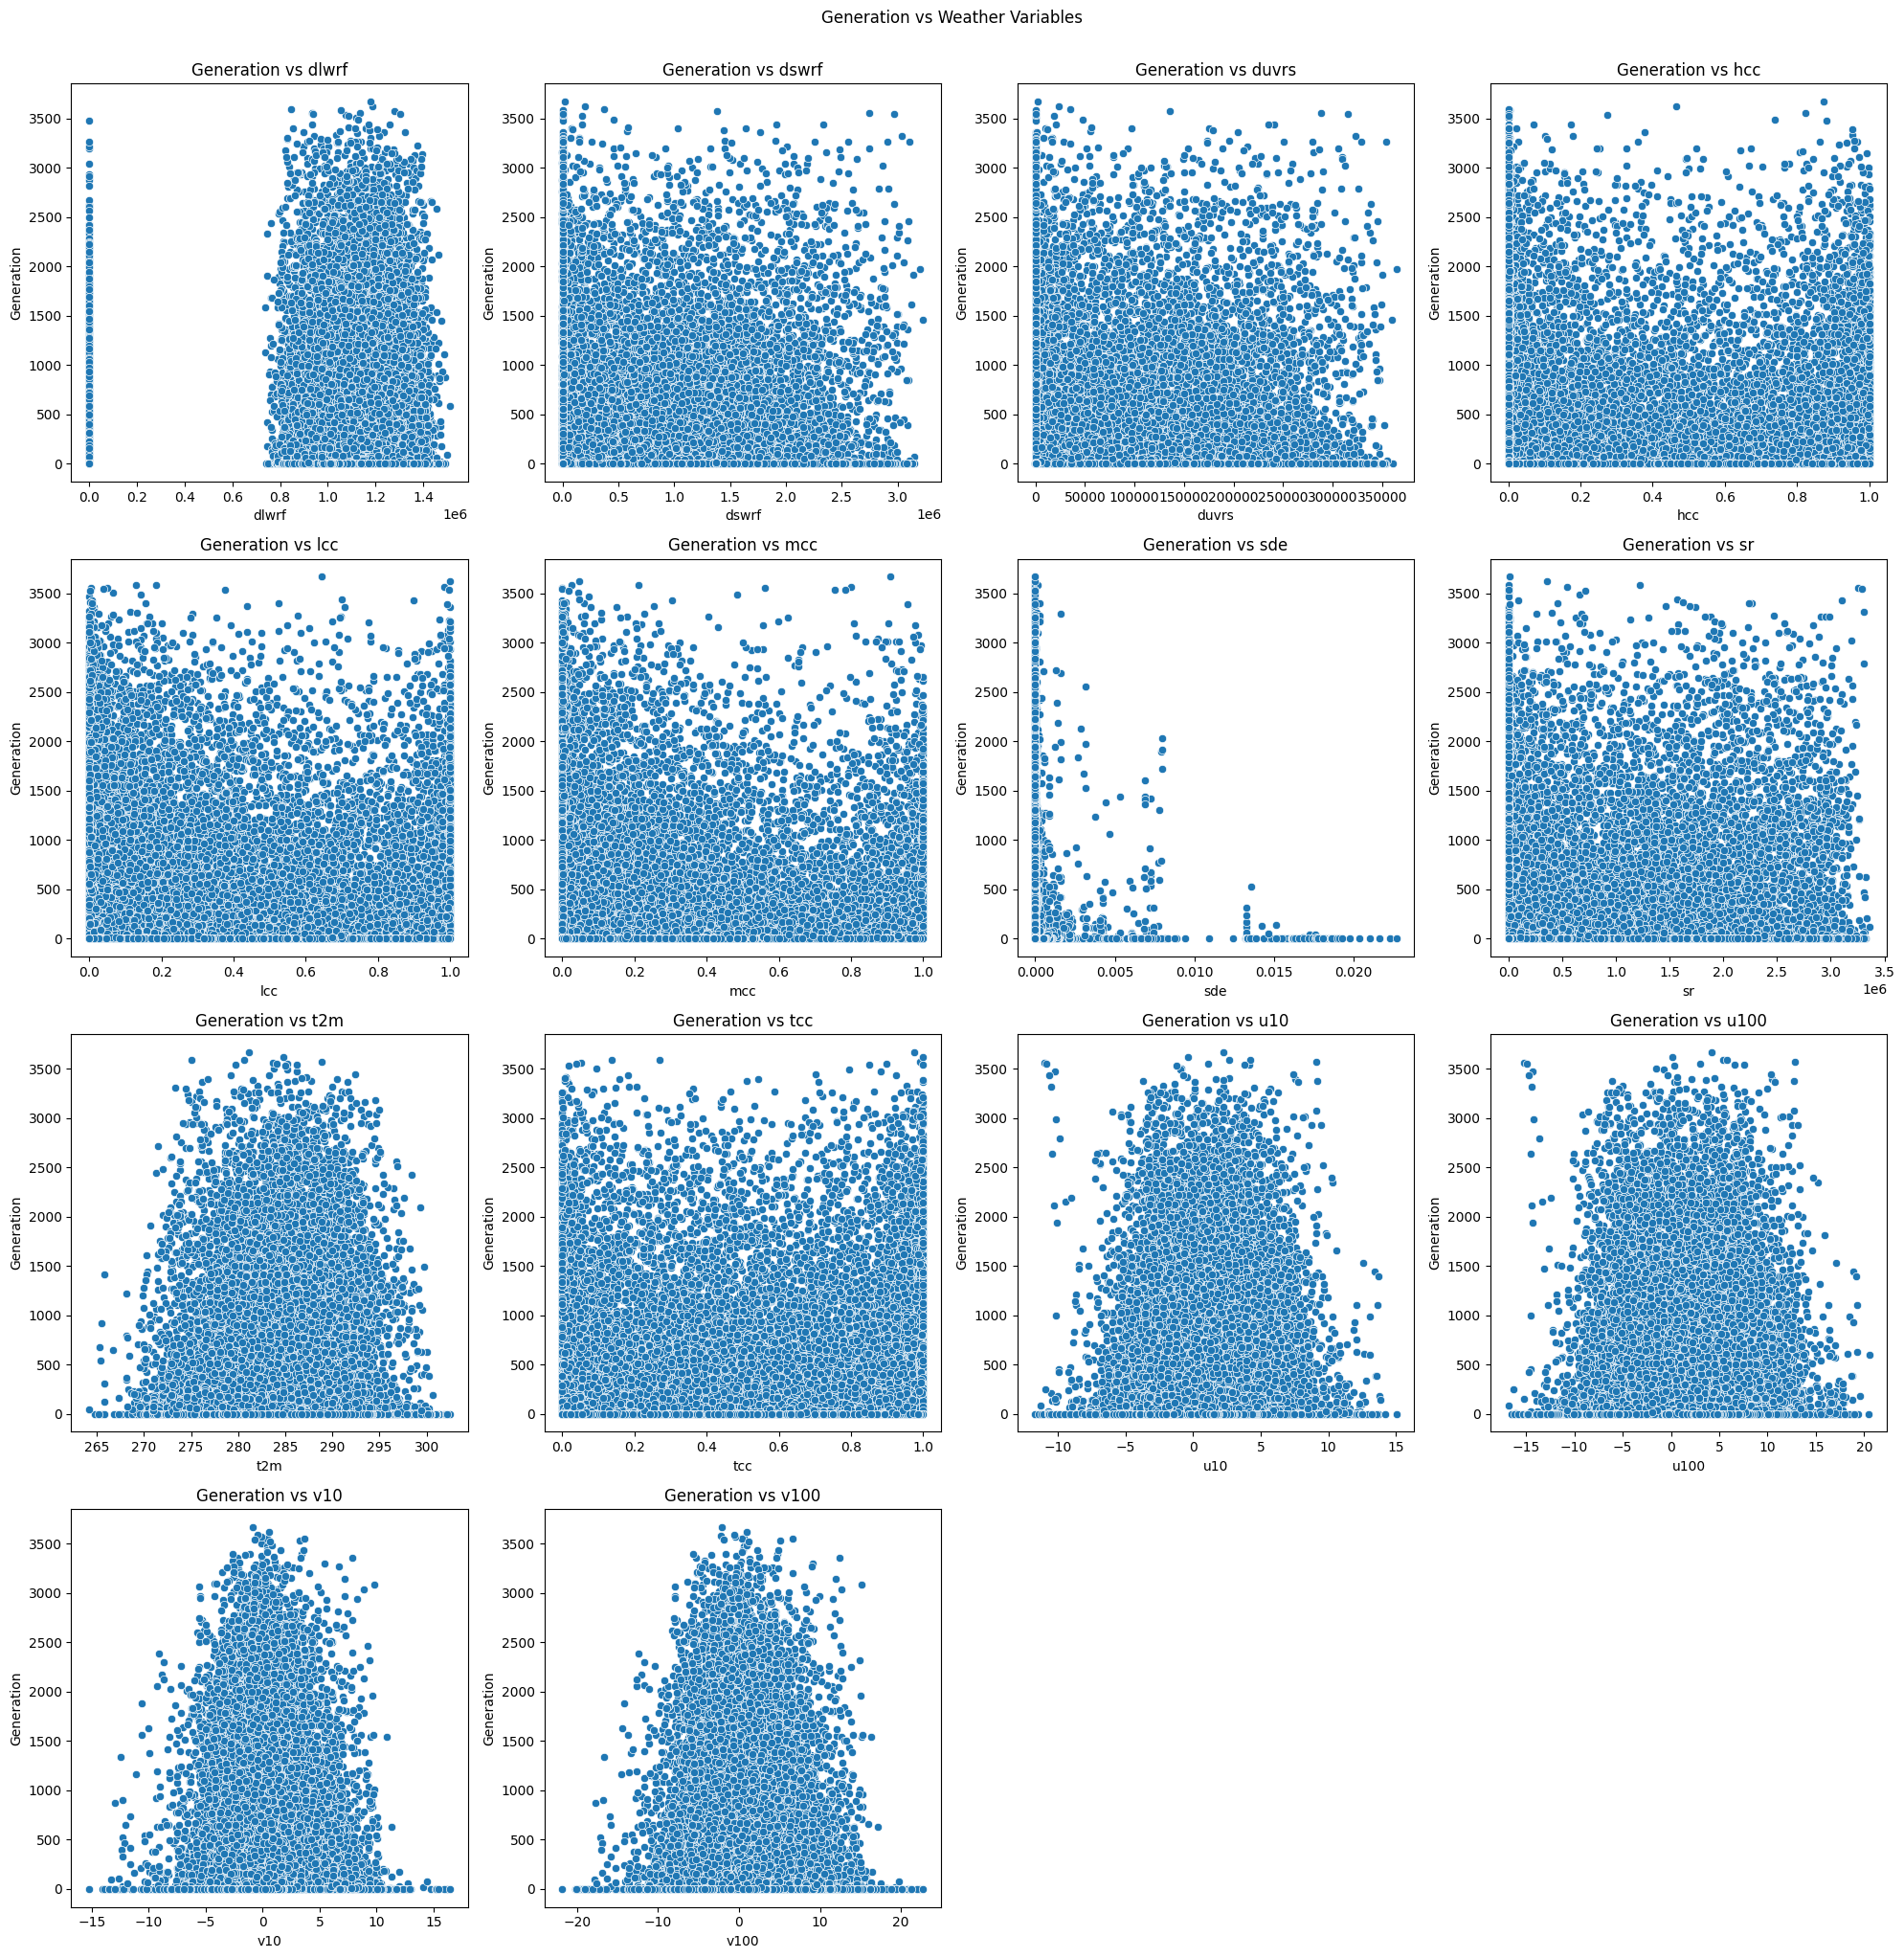

In [8]:
weather_variables = ['dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10', 'v100']


num_vars = len(weather_variables)
cols = 4
rows = (num_vars + cols - 1) // cols  # Ceiling division for grid layout

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, var in enumerate(weather_variables):
    sns.scatterplot(data=forecast_data, x=var, y='generation', ax=axes[i])
    axes[i].set_title(f'Generation vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Generation')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Generation vs Weather Variables', y=1.02)
plt.show()

In [9]:
forecast_data.columns

Index(['ss_id', 'init_time', 'step', 'pv_datetime', 'day_hour', 'horizon',
       'generation', 'capacity', 'normalize_generation', 'lat', 'long', 'tilt',
       'orientation', 'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde',
       'sr', 't2m', 'tcc', 'u10', 'u100', 'v10', 'v100', 'date', 'day_of_week',
       'month'],
      dtype='object')

In [10]:
target_variable = 'normalize_generation'
static_features = ['ss_id', 'capacity', 'lat', 'long', 'tilt', 'orientation']
known_future_inputs = [
    'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 
    't2m', 'tcc', 'u10', 'u100', 'v10', 'v100', 'day_of_week', 'month', 'day_hour'
]

required_columns = static_features + known_future_inputs + [target_variable, 'pv_datetime', 'date']
# skipping init time and step and horizon

forecast_data = forecast_data[required_columns]

forecast_data = forecast_data.fillna(method='bfill').fillna(method='ffill')

forecast_data['time_idx'] = forecast_data.index

In [11]:
forecast_data['time_idx']

0            0
1            1
2            2
3            3
4            4
         ...  
48343    48343
48344    48344
48345    48345
48346    48346
48347    48347
Name: time_idx, Length: 48348, dtype: int64

In [12]:
# print(forecast_data.columns)

forecast_data.dtypes

ss_id                            int64
capacity                       float64
lat                            float64
long                           float64
tilt                           float64
orientation                    float64
dlwrf                          float64
dswrf                          float64
duvrs                          float64
hcc                            float64
lcc                            float64
mcc                            float64
sde                            float64
sr                             float64
t2m                            float64
tcc                            float64
u10                            float64
u100                           float64
v10                            float64
v100                           float64
day_of_week                      int32
month                            int32
day_hour                       float64
normalize_generation           float64
pv_datetime             datetime64[ns]
date                     

In [13]:
max_encoder_length = 36
# 36 *4 , how much value model should see in the past, 3 batches past, later doing max encoder length //2
## should have continous batches of 72 hours, If your dataset does not have enough contiguous historical data to form these sequences, or if there are gaps in the data, you might encounter issues with size mismatches.
max_prediction_length = 36

- keep it continous
- let's just do 36 hours
- check the minimum, 36, if not remove it. 
- init time 2 adjacent values has 12 hours gap. 
- use only 36 steps
- even if nwp data is missing, it is fine to give nans. model will learn
- start with 36 hours forecast
- select a lot from pv, get rid of nans, and get it for training for next steps

- pick one specific datetime , make a graph, one forecast batch, look what clouds are doing, what generation is like, 

In [14]:
training_cutoff = forecast_data["pv_datetime"].max() - pd.Timedelta(hours=max_prediction_length)
training_data = forecast_data[forecast_data["pv_datetime"] <= training_cutoff]
print(len(training_data))

48132


In [15]:
forecast_data['ss_id'] = forecast_data['ss_id'].astype(str)
forecast_data['day_of_week'] = forecast_data['day_of_week'].astype(str)
forecast_data['month'] = forecast_data['month'].astype(str)
forecast_data['day_hour'] = forecast_data['day_hour'].astype(str)


In [16]:
# Ensure time_idx is of string type
forecast_data['time_idx'] = forecast_data['time_idx'].astype(int)


In [17]:
training = TimeSeriesDataSet(
    forecast_data[lambda x: x.pv_datetime <= training_cutoff],
    time_idx="time_idx",
    target="normalize_generation",
    group_ids=["ss_id"],  # Grouping by ss_id to identify different PV sites
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["capacity", "lat", "long", "tilt", "orientation"],
    time_varying_known_categoricals=[ "month", "day_of_week", "day_hour"],
    time_varying_known_reals=["time_idx", "dlwrf", "dswrf", "duvrs", "hcc", "lcc", "mcc", "sde", "sr", "t2m", "tcc", "u10", "u100", "v10", "v100"],
    time_varying_unknown_reals=["normalize_generation"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=False,
)


In [18]:
validation = TimeSeriesDataSet.from_dataset(training, forecast_data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
# # print(validation)

In [19]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [20]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="my_model")

In [21]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

trainer = pl.Trainer(
    max_epochs=50,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=logger
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 44.5k


Finding best initial lr: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]
Learning rate set to 0.061003900355223004
Restoring states from the checkpoint path at /home/rosh/gsoc-data/.lr_find_ad169f83-71f6-471b-b958-a0ad499111fd.ckpt
Restored all states from the checkpoint at /home/rosh/gsoc-data/.lr_find_ad169f83-71f6-471b-b958-a0ad499111fd.ckpt


suggested learning rate: 0.061003900355223004


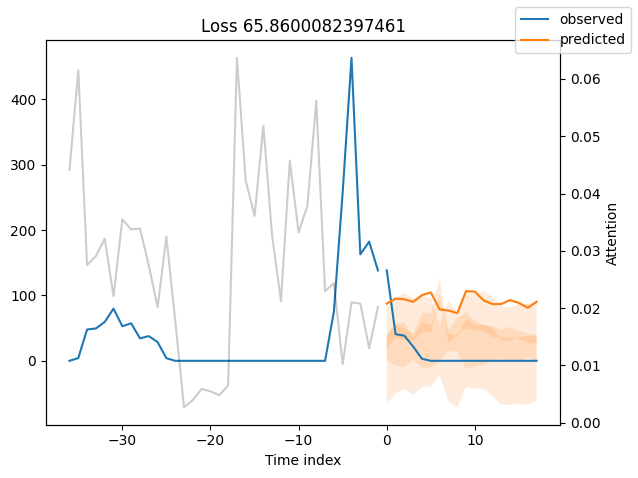

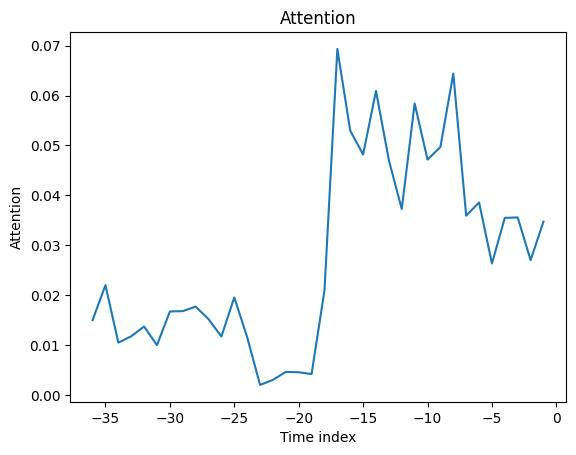

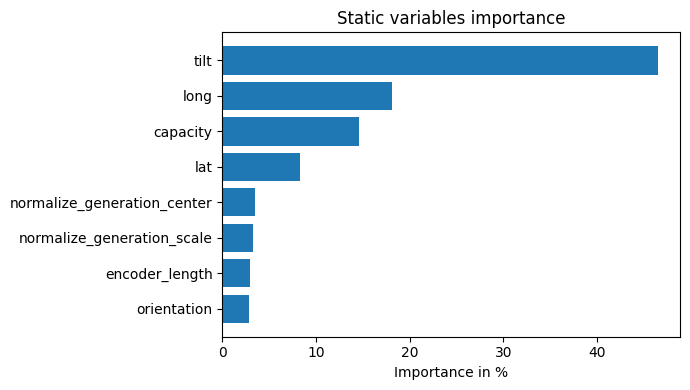

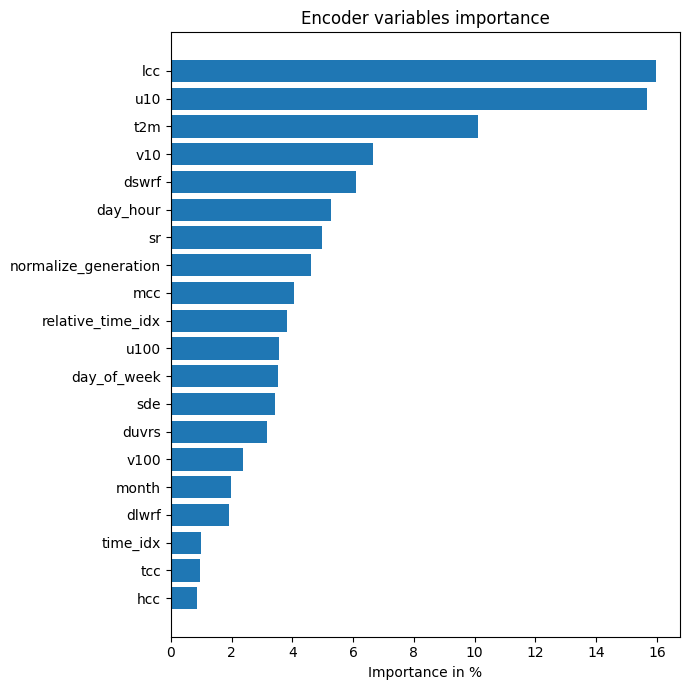

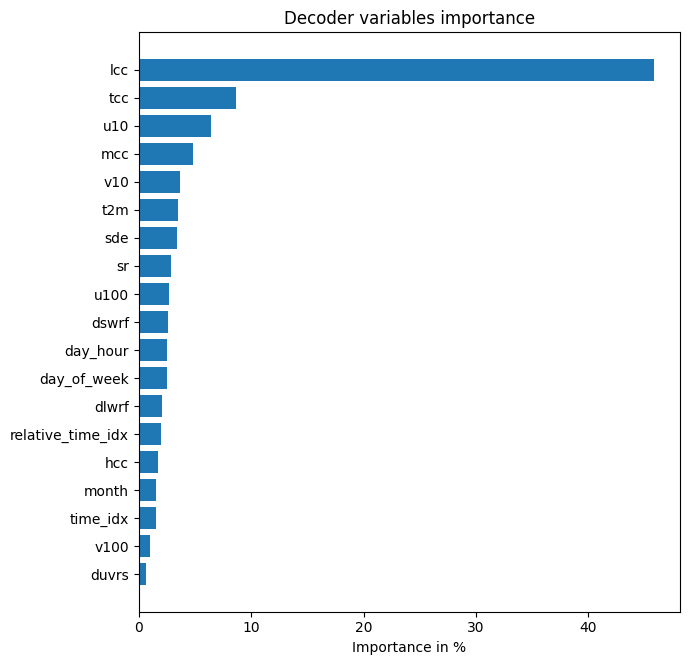

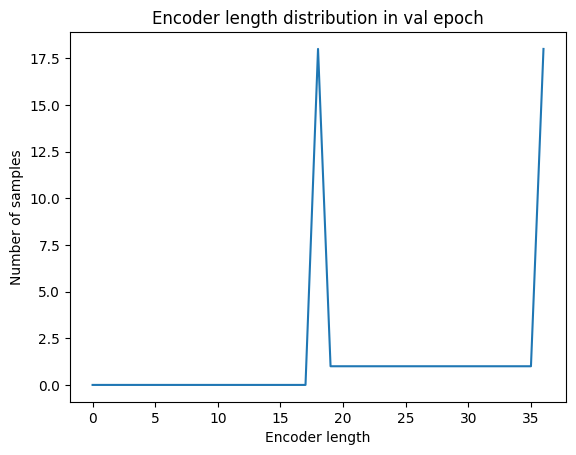

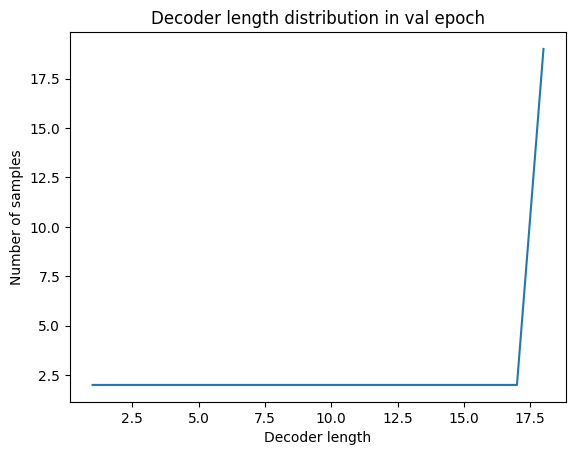

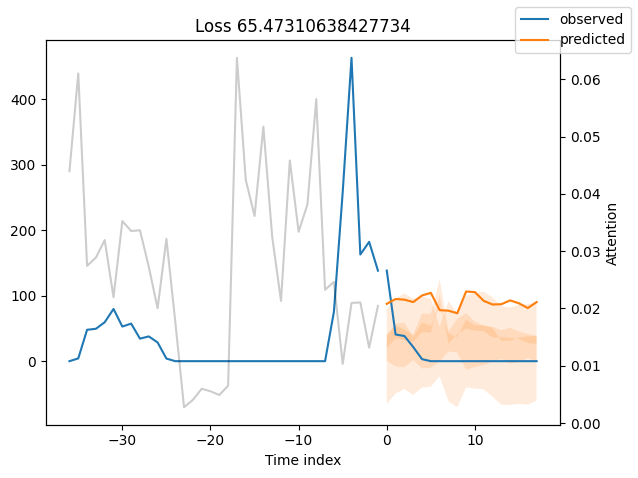

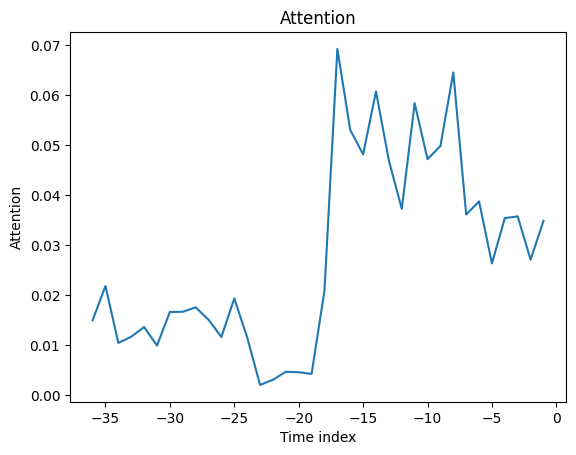

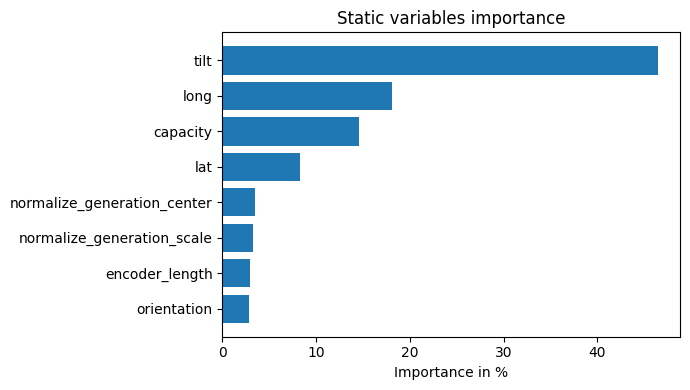

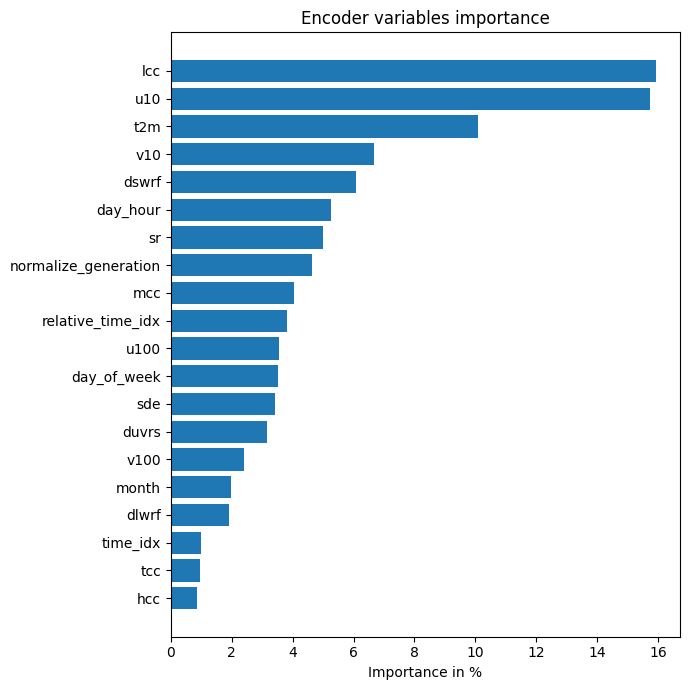

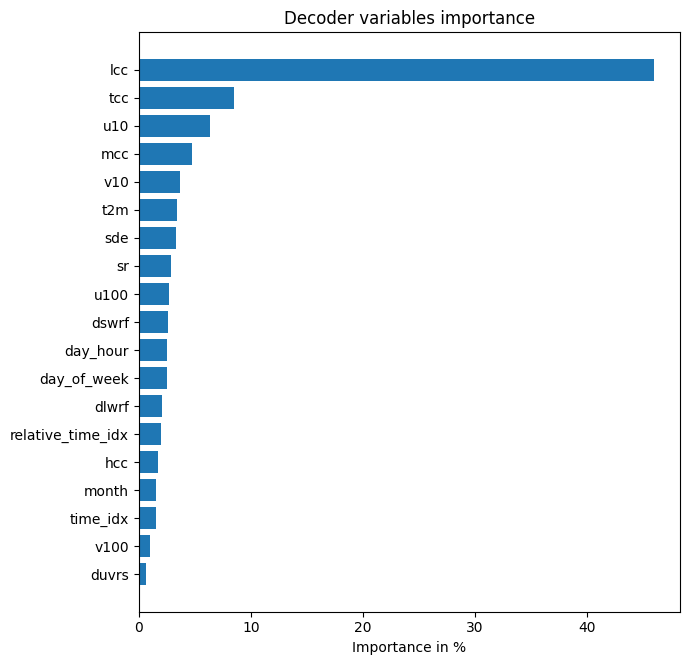

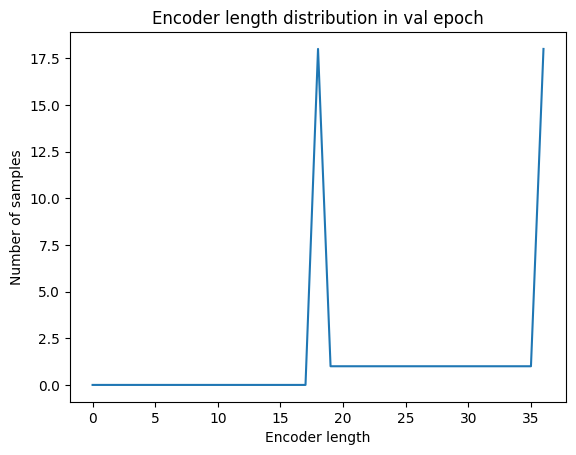

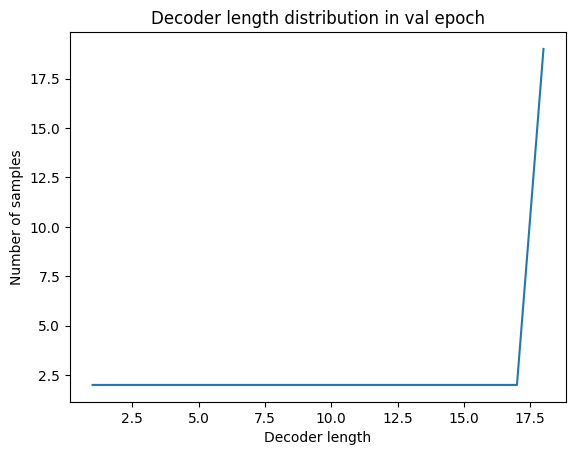

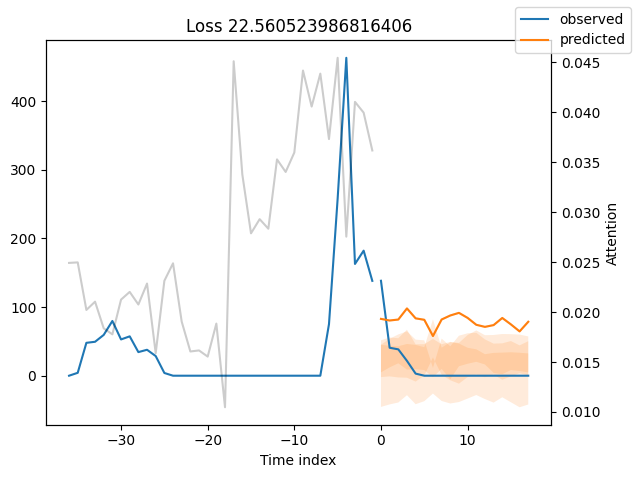

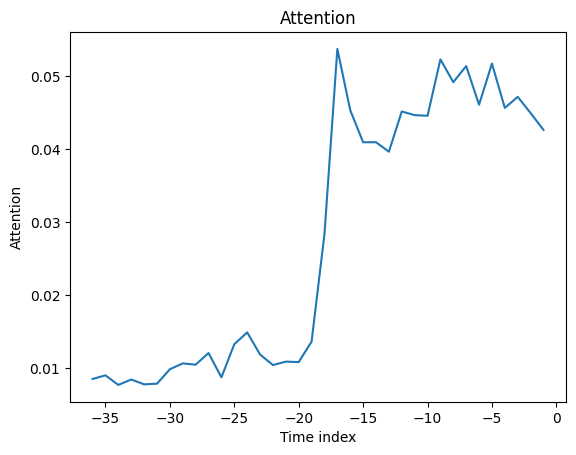

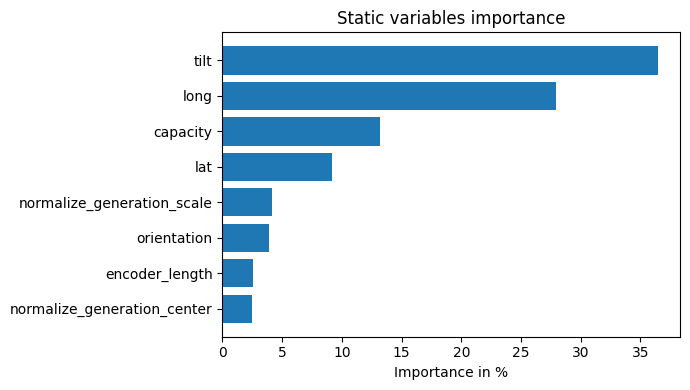

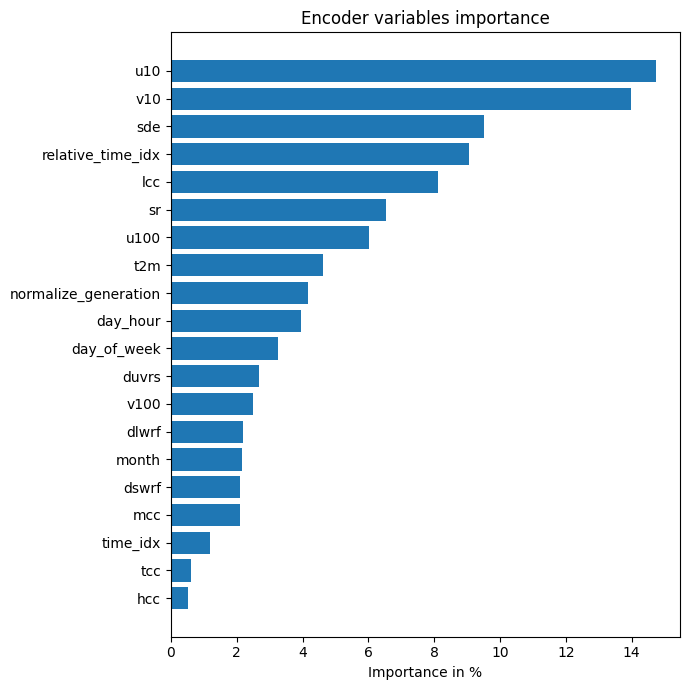

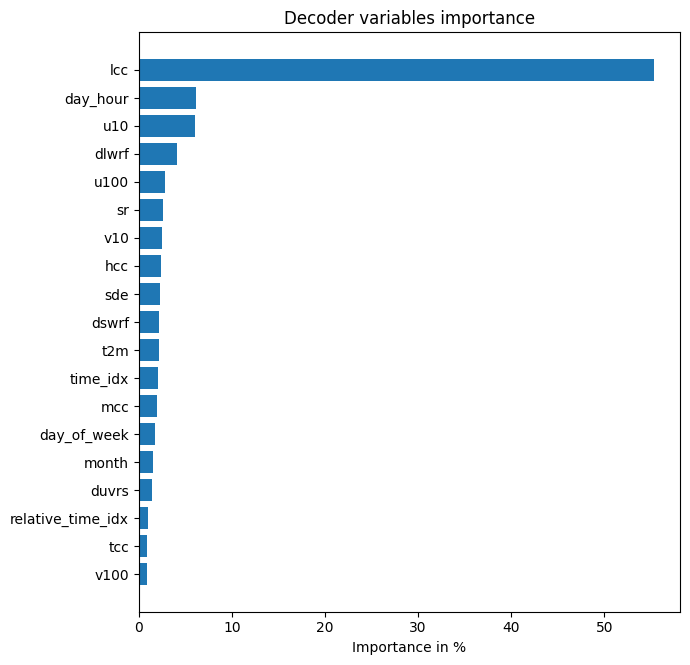

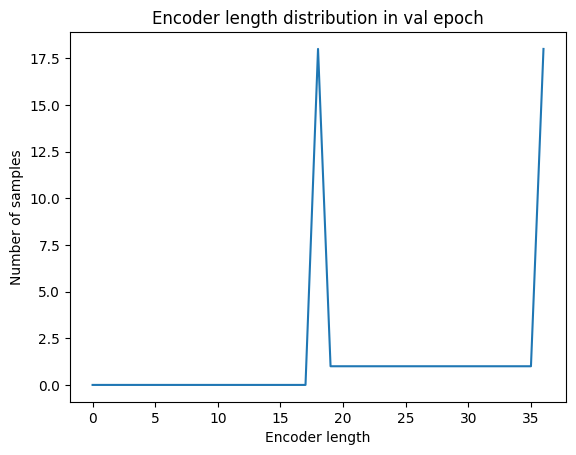

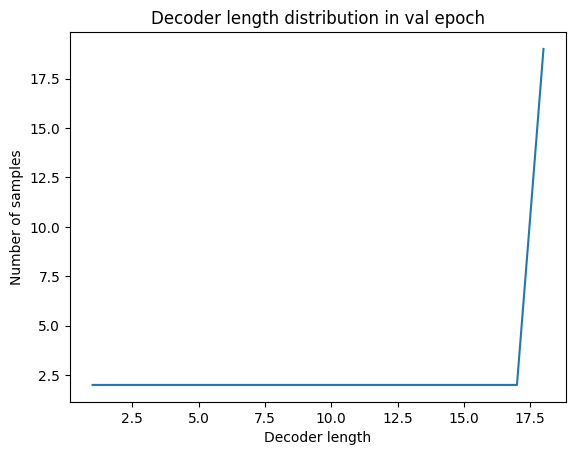

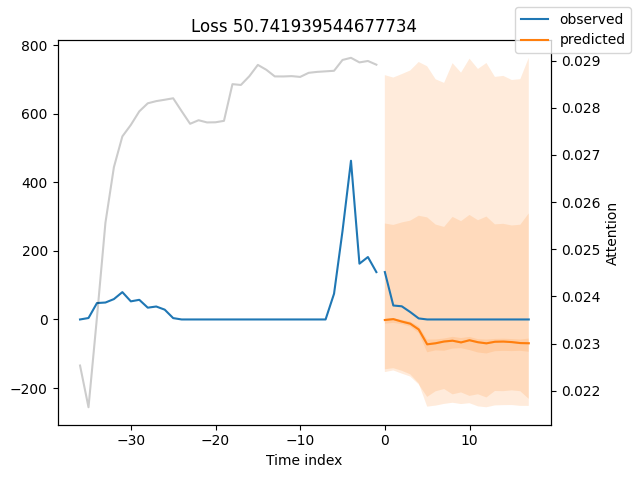

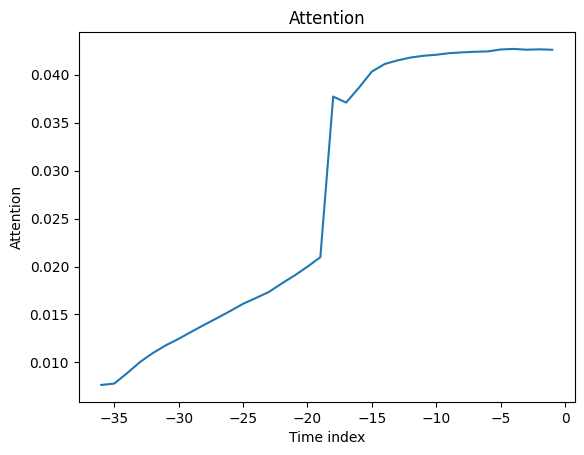

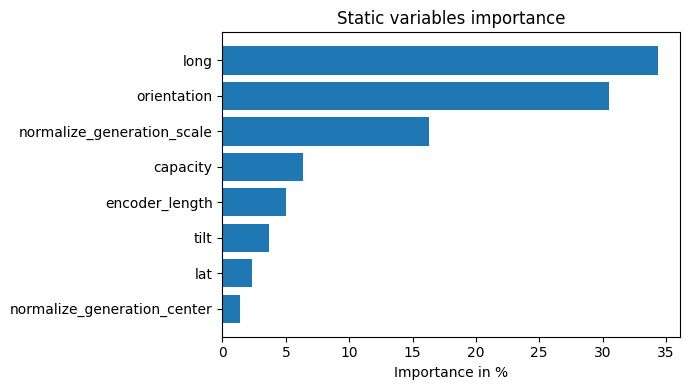

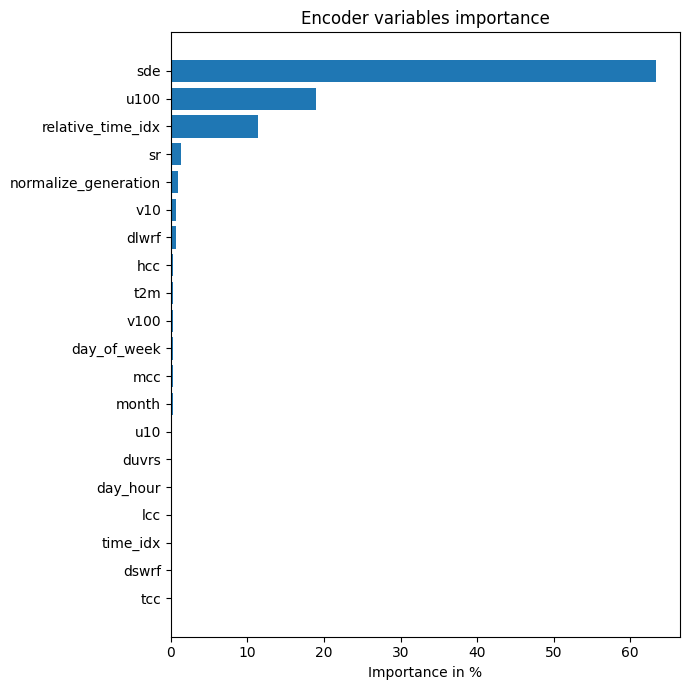

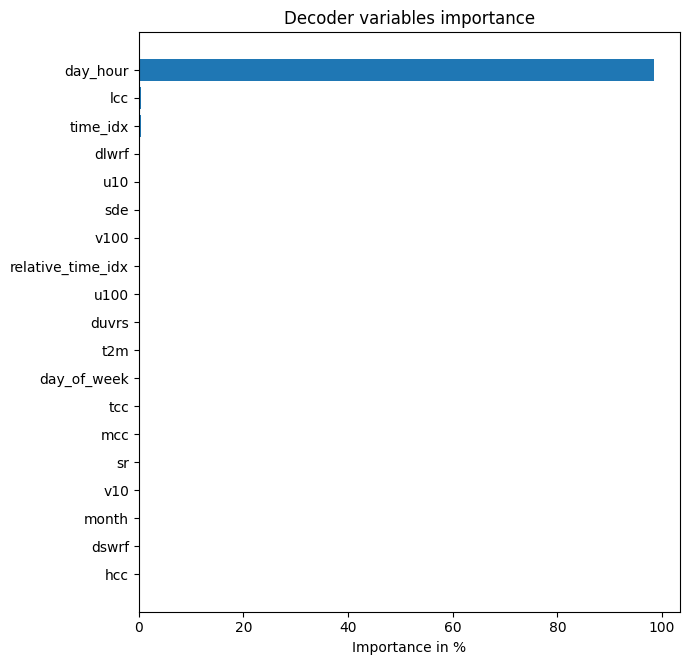

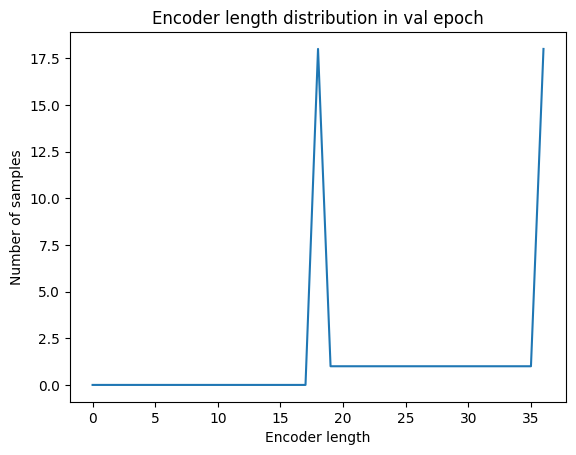

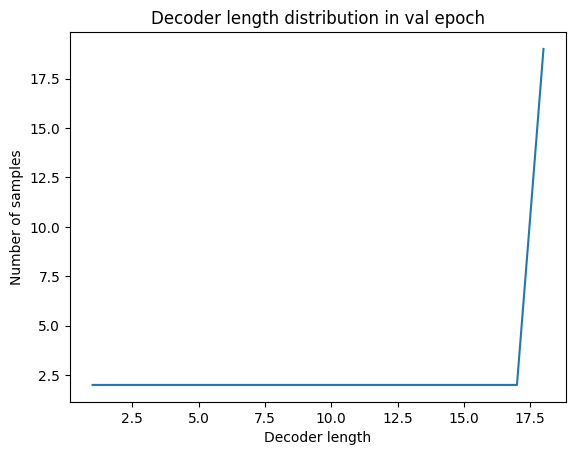

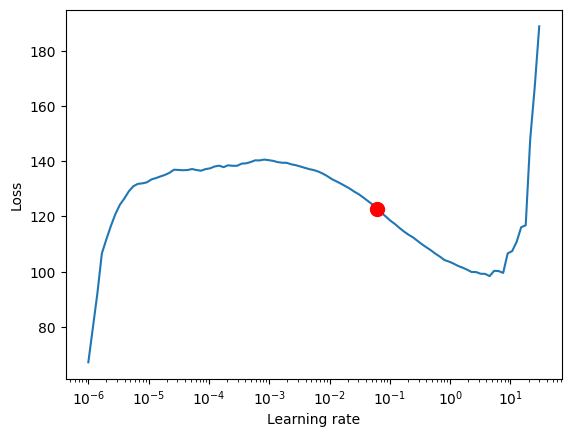

In [22]:
tuner = Tuner(trainer)
res = tuner.lr_find(
     tft,
     train_dataloaders=train_dataloader,
     val_dataloaders=val_dataloader,
     max_lr=30.0,
     min_lr=1e-6,
 )

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [23]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 323    | train
3  | prescalers                         | ModuleDict                      | 400    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.9 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.2 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 49: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s, v_num=20, train_loss_step=22.70, val_loss=3.570, train_loss_epoch=22.90]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, v_num=20, train_loss_step=22.70, val_loss=3.570, train_loss_epoch=22.90]


In [26]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/my_model/version_20/checkpoints/epoch=49-step=1500.ckpt


In [27]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
print("Checking for NaN values in actuals and predictions...")
print("Number of NaNs in actuals:", torch.isnan(actuals).sum().item())
print("Number of NaNs in predictions:", torch.isnan(predictions).sum().item())


Checking for NaN values in actuals and predictions...
Number of NaNs in actuals: 0
Number of NaNs in predictions: 306


In [29]:
print(f"Actuals size: {actuals.size()}")
print(f"Predictions size: {predictions.size()}")


Actuals size: torch.Size([53, 18])
Predictions size: torch.Size([53, 18])


In [30]:

print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))


nan
tensor([4.7277, 4.6292, 4.5239, 4.4594, 4.4507, 4.4645, 4.4791, 4.5001, 4.5110,
        4.5571, 4.6595, 4.9175, 4.8412, 4.6857, 4.6462, 4.7548, 4.9454, 5.1422,
        5.3889,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan])


In [31]:
print("Actuals:", actuals.tolist())
print("Predictions:", predictions.tolist())

Actuals: [[138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.35940551757812, 40.732330322265625, 38.41473388671875, 21.633203506469727, 3.046736717224121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

In [32]:
mae = (actuals - predictions).abs().mean().item()
print(f"Mean Absolute Error: {mae}")

# Print the average p50 loss per time series
average_p50_loss = (actuals - predictions).abs().mean(axis=1)
print(f"Average P50 Loss per Time Series: {average_p50_loss}")


Mean Absolute Error: nan
Average P50 Loss per Time Series: tensor([4.7277, 4.6292, 4.5239, 4.4594, 4.4507, 4.4645, 4.4791, 4.5001, 4.5110,
        4.5571, 4.6595, 4.9175, 4.8412, 4.6857, 4.6462, 4.7548, 4.9454, 5.1422,
        5.3889,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan])


In [33]:
mask = ~torch.isnan(actuals) & ~torch.isnan(predictions)
actuals_filtered = actuals[mask]
predictions_filtered = predictions[mask]

# Calculate MAE
mae = (actuals_filtered - predictions_filtered).abs().mean().item()
print(f"Mean Absolute Error: {mae}")




Mean Absolute Error: 5.000213623046875
